# Part1. LSTM Model

## Setting and Import

In [ ]:
# Global Variables
ROUND = 103

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output

In [ ]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

## Preprocessing
* Change input data (ex. train.txt) into CRF model input format (ex. train.data)
    * CRF model input format (ex. train.data):
        ```
        肝 O
        功 O
        能 O
        6 B-med_exam
        8 I-med_exam
        ```

In [ ]:
file_path = '/content/drive/MyDrive/nlp_data_2/train_new.txt'

In [ ]:
def loadInputFile(path):
    trainingset = list()  # store trainingset [content,content,...]
    position = list()  # store position [article_id, start_pos, end_pos, entity_text, entity_type, ...]
    mentions = dict()  # store mentions[mention] = Type
    with open(file_path, 'r', encoding='utf8') as f:
        file_text=f.read().encode('utf-8').decode('utf-8-sig')
    datas=file_text.split('\n\n--------------------\n\n')[:-1]
    for data in datas:
        data=data.split('\n')
        content=data[0]
        trainingset.append(content)
        annotations=data[1:]
        for annot in annotations[1:]:
            annot=annot.split('\t') #annot= article_id, start_pos, end_pos, entity_text, entity_type
            position.extend(annot)
            mentions[annot[3]]=annot[4]
    
    return trainingset, position, mentions

In [ ]:
def CRFFormatData(trainingset, position, path):
    if (os.path.isfile(path)):
        os.remove(path)
    outputfile = open(path, 'a', encoding= 'utf-8')

    # output file lines
    count = 0 # annotation counts in each content
    tagged = list()
    for article_id in range(len(trainingset)):
        trainingset_split = list(trainingset[article_id])
        while '' or ' ' in trainingset_split:
            if '' in trainingset_split:
                trainingset_split.remove('')
            else:
                trainingset_split.remove(' ')
        start_tmp = 0
        for position_idx in range(0,len(position),5):
            if int(position[position_idx]) == article_id:
                count += 1
                if count == 1:
                    start_pos = int(position[position_idx+1])
                    end_pos = int(position[position_idx+2])
                    entity_type=position[position_idx+4]
                    if start_pos == 0:
                        token = list(trainingset[article_id][start_pos:end_pos])
                        whole_token = trainingset[article_id][start_pos:end_pos]
                        for token_idx in range(len(token)):
                            if len(token[token_idx].replace(' ','')) == 0:
                                continue
                            # BIO states
                            if token_idx == 0:
                                label = 'B-'+entity_type
                            else:
                                label = 'I-'+entity_type
                            
                            output_str = token[token_idx] + ' ' + label + '\n'
                            outputfile.write(output_str)

                    else:
                        token = list(trainingset[article_id][0:start_pos])
                        whole_token = trainingset[article_id][0:start_pos]
                        for token_idx in range(len(token)):
                            if len(token[token_idx].replace(' ','')) == 0:
                                continue
                            
                            output_str = token[token_idx] + ' ' + 'O' + '\n'
                            outputfile.write(output_str)

                        token = list(trainingset[article_id][start_pos:end_pos])
                        whole_token = trainingset[article_id][start_pos:end_pos]
                        for token_idx in range(len(token)):
                            if len(token[token_idx].replace(' ','')) == 0:
                                continue
                            # BIO states
                            if token[0] == '':
                                if token_idx == 1:
                                    label = 'B-'+entity_type
                                else:
                                    label = 'I-'+entity_type
                            else:
                                if token_idx == 0:
                                    label = 'B-'+entity_type
                                else:
                                    label = 'I-'+entity_type

                            output_str = token[token_idx] + ' ' + label + '\n'
                            outputfile.write(output_str)

                    start_tmp = end_pos
                else:
                    start_pos = int(position[position_idx+1])
                    end_pos = int(position[position_idx+2])
                    entity_type=position[position_idx+4]
                    if start_pos<start_tmp:
                        continue
                    else:
                        token = list(trainingset[article_id][start_tmp:start_pos])
                        whole_token = trainingset[article_id][start_tmp:start_pos]
                        for token_idx in range(len(token)):
                            if len(token[token_idx].replace(' ','')) == 0:
                                continue
                            output_str = token[token_idx] + ' ' + 'O' + '\n'
                            outputfile.write(output_str)

                    token = list(trainingset[article_id][start_pos:end_pos])
                    whole_token = trainingset[article_id][start_pos:end_pos]
                    for token_idx in range(len(token)):
                        if len(token[token_idx].replace(' ','')) == 0:
                            continue
                        # BIO states
                        if token[0] == '':
                            if token_idx == 1:
                                label = 'B-'+entity_type
                            else:
                                label = 'I-'+entity_type
                        else:
                            if token_idx == 0:
                                label = 'B-'+entity_type
                            else:
                                label = 'I-'+entity_type
                        
                        output_str = token[token_idx] + ' ' + label + '\n'
                        outputfile.write(output_str)
                    start_tmp = end_pos

        token = list(trainingset[article_id][start_tmp:])
        whole_token = trainingset[article_id][start_tmp:]
        for token_idx in range(len(token)):
            if len(token[token_idx].replace(' ','')) == 0:
                continue

            
            output_str = token[token_idx] + ' ' + 'O' + '\n'
            outputfile.write(output_str)

        count = 0
    
        output_str = '\n'
        outputfile.write(output_str)
        ID = trainingset[article_id]

        if article_id%10 == 0:
            print('Total complete articles:', article_id)

    # close output file
    outputfile.close()

In [ ]:
trainingset, position, mentions=loadInputFile(file_path)

In [ ]:
data_path='output.tsv'
CRFFormatData(trainingset, position, data_path)

Total complete articles: 0
Total complete articles: 10
Total complete articles: 20
Total complete articles: 30
Total complete articles: 40
Total complete articles: 50
Total complete articles: 60
Total complete articles: 70
Total complete articles: 80
Total complete articles: 90
Total complete articles: 100
Total complete articles: 110
Total complete articles: 120
Total complete articles: 130
Total complete articles: 140
Total complete articles: 150
Total complete articles: 160
Total complete articles: 170
Total complete articles: 180
Total complete articles: 190
Total complete articles: 200


In [ ]:
def Dataset(data_path):
    with open(data_path, 'r', encoding='utf-8') as f:
        data=f.readlines()#.encode('utf-8').decode('utf-8-sig')
    data_list, data_list_tmp = list(), list()
    article_id_list=list()
    idx=0
    for row in data:
        data_tuple = tuple()
        if row == '\n':
            article_id_list.append(idx)
            idx+=1
            data_list.append(data_list_tmp)
            data_list_tmp = []
        else:
            row = row.strip('\n').split(' ')
            data_tuple = (row[0], row[1])
            data_list_tmp.append(data_tuple)
    if len(data_list_tmp) != 0:
        data_list.append(data_list_tmp)

    return data_list, article_id_list 

In [ ]:
traindata_list, traindata_article_id_list = Dataset(data_path)

## Get Input Feature (BERT Embedding)

In [ ]:
!pip install transformers
clear_output()

### 切割資料與標籤 (Length=512)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from keras.utils import to_categorical
import random

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
bert_model = BertModel.from_pretrained('bert-base-chinese')

# 將每個句子保留在 512 個字元以內，若超過則切成兩個句子
def split_sentence(data_list):
    # final word vector list
    new_sentence_list = list()
    for idx_list in range(len(data_list)):
        sentence_list = [each[0] for each in data_list[idx_list]]
        while len(sentence_list) > 512:
            new_sentence_list.append(sentence_list[:512])
            sentence_list = sentence_list.copy()[512:]
        new_sentence_list.append(sentence_list)
    return new_sentence_list

def split_tag(data_list):
    new_tag_list = list()
    for idx_list in range(len(data_list)):
        tag_list = [each[1] for each in data_list[idx_list]]
        while len(tag_list) > 512:
            new_tag_list.append(tag_list[:512])
            tag_list = tag_list.copy()[512:]
        new_tag_list.append(tag_list)
    return new_tag_list

# 查看總共有哪些 label
tags = list(set([tag[1] for article in traindata_list for tag in article]))
# 標籤數量
n_tags = len(tags)
# 標籤與 index 轉換
tag2idx = {t:i for i, t in enumerate(tags)}

# 對標籤做 padding
def get_tag(new_tag_list):
    res_y_list = list()
    for tag in new_tag_list:
        # Handle tag
        while len(tag) < 512:
            tag.append("O")
        tag = [tag2idx[t] for t in tag]
        tag = to_categorical(tag, num_classes=n_tags)
        res_y_list.append(tag)
    return res_y_list

In [ ]:
# 取得切割過後的句子與標籤
new_sentence_list = split_sentence(traindata_list[:])
new_tag_list = split_tag(traindata_list[:])

### 計算 Class Weight

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weight
y_train_temp = get_tag(new_tag_list)
y_integers = np.argmax(np.array([x for each in y_train_temp for x in each]), axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
# weight dict
d_class_weights = dict(enumerate(class_weights))

### 取得最終訓練資料

In [ ]:
# function to generate sample weight
def generate_sample_weights(training_data, class_weight_dictionary): 
    sample_weights = [class_weight_dictionary[np.where(one_hot_row==1)[0][0]] for one_hot_row in training_data]
    return np.asarray(sample_weights)

# 取得 BERT Embedding 過後的 Training Data，以及目標標籤，並透過 Generator 來減少記憶體使用量
def get_x_y(new_sentence_list, new_tag_list, batch_size):
    y_len = len(new_tag_list)
    loop_count = y_len // batch_size
    while True:
        idx = random.randint(0,loop_count-1) 
        # get word embedding lists and tags with generator
        res_x_list, res_y_list = list(), list()
        for i in range(idx * batch_size, (idx+1) * batch_size):
            sentence = new_sentence_list[i].copy()
            tag = new_tag_list[i].copy()
            # Handle char to embedding
            inputs = [tokenizer.convert_tokens_to_ids(text) for text in list(sentence)]
            padding_num = 512 - len(inputs)
            input_ids = torch.tensor([inputs+[0]*padding_num])
            token_type_ids = torch.tensor([[0]*512])
            attention_mask = torch.tensor([[1]*len(inputs)+[0]*padding_num])
            final_inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
            outputs = bert_model(**final_inputs).last_hidden_state[0]
            word_vector_list = [word.detach().numpy() for word in outputs]
            res_x_list.append(word_vector_list)
            # Handle tag
            while len(tag) < 512:
                tag.append("O")
            tag = [tag2idx[t] for t in tag]
            tag = to_categorical(tag, num_classes=n_tags)
            res_y_list.append(tag)
        sample_weight = generate_sample_weights(res_y_list, d_class_weights)
        yield (np.array(res_x_list), np.array(res_y_list), sample_weight)

## LSTM with Keras

In [ ]:
import numpy as np
import tensorflow
import keras
import keras.backend as K
from keras import Sequential, Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.utils import plot_model

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

### Build LSTM Model

In [ ]:
def get_model():
    model = Sequential(name="bert_lstm")
    model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), input_shape=(512, 768), name="output1"))
    model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), name="output2"))
    model.add(TimeDistributed(Dense(n_tags, activation="softmax"), name="output3")) 
    adam = keras.optimizers.Adam(lr=6e-4, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    # loss=ncce
    model.summary()
    return model

Model: "bert_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output1 (Bidirectional)      (None, 512, 256)          918528    
_________________________________________________________________
output2 (Bidirectional)      (None, 512, 256)          394240    
_________________________________________________________________
output3 (TimeDistributed)    (None, 512, 27)           6939      
Total params: 1,319,707
Trainable params: 1,319,707
Non-trainable params: 0
_________________________________________________________________


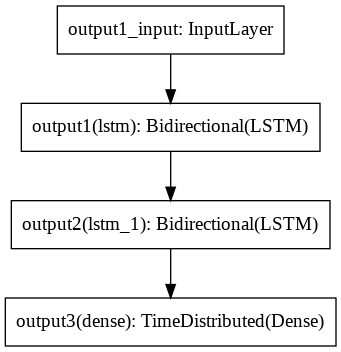

In [ ]:
model = get_model()
plot_model(model)

### Train LSTM Model

In [ ]:
file_path = f'/content/drive/MyDrive/nlp_data_2/lstm_model/bert_lstm_{ROUND}'
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
chk_file_path = "/content/drive/MyDrive/nlp_data_2/lstm_model/saved-model-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(chk_file_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit_generator(get_x_y(new_sentence_list, new_tag_list, 16), steps_per_epoch=len(new_sentence_list)//16, epochs=25, callbacks=[early_stopping, checkpoint], validation_data=get_x_y(new_sentence_list, new_tag_list, 16), validation_steps=4)
# class_weight=d_class_weights
model.save(file_path)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
58/58 [==============================] - 1882s 33s/step - loss: 24.6813 - accuracy: 0.8966 - val_loss: 6.5948 - val_accuracy: 0.9747

Epoch 00001: val_loss improved from inf to 6.59479, saving model to /content/drive/MyDrive/nlp_data_2/lstm_model/saved-model-01-6.59.hdf5
Epoch 2/25
58/58 [==============================] - 1879s 33s/step - loss: 5.5804 - accuracy: 0.9784 - val_loss: 5.6311 - val_accuracy: 0.9681

Epoch 00002: val_loss improved from 6.59479 to 5.63108, saving model to /content/drive/MyDrive/nlp_data_2/lstm_model/saved-model-02-5.63.hdf5
Epoch 3/25
58/58 [==============================] - 1843s 32s/step - loss: 3.2630 - accuracy: 0.9818 - val_loss: 2.2315 - val_accuracy: 0.9868

Epoch 00003: val_loss improved from 5.63108 to 2.23149, saving model to /content/drive/MyDrive/nlp_data_2/lstm_model/saved-model-03-2.23.hdf5
Epoch 4/25
58/58 [==============================] - 1882s 33s/step - loss: 3.0731 - accuracy: 0.9820 - val_loss: 3.3188 - val_accuracy: 0.9785

E

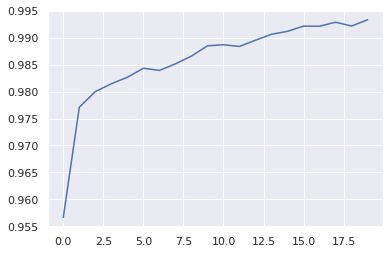

In [ ]:
# draw history accuracy change
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history["accuracy"]
plt.plot(acc, "b-", label="acc")
plt.show()

In [ ]:
print(tag2idx)

{'I-location': 0, 'I-others': 1, 'I-profession': 2, 'B-time': 3, 'B-ID': 4, 'I-organization': 5, 'B-location': 6, 'B-name': 7, 'I-family': 8, 'I-med_exam': 9, 'B-organization': 10, 'B-clinical_event': 11, 'I-ID': 12, 'I-time': 13, 'B-med_exam': 14, 'B-others': 15, 'B-profession': 16, 'B-education': 17, 'I-contact': 18, 'O': 19, 'B-family': 20, 'I-clinical_event': 21, 'I-education': 22, 'B-contact': 23, 'I-name': 24, 'I-money': 25, 'B-money': 26}
